In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve
from scipy.signal import unit_impulse
from scipy.signal import welch
from scipy.fftpack import fft
from scipy.fftpack import fftfreq
from scipy.fftpack import fftshift
from scipy.fftpack import ifft
from scipy.fftpack import ifftshift
import seaborn as sns
sns.set()

$25 \rm{Hz}$，$50 \rm{Hz}$，$75 \rm{Hz}$の正弦波を重畳したディジタル信号から，$25 \rm{Hz}$の正弦波を抽出するディジタルフィルタについて`Python 3.6.5`でプログラムしながら勉強しました．

まず，今回使用するモジュールと関数をインポートします．

In [2]:
SAMPLING_RATE = 512
TIME = 1

t = np.linspace(0, TIME, TIME * SAMPLING_RATE)
x = np.sin(2 * np.pi * 25 * t) + np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 75 * t)

$25 \rm{Hz}$，$50 \rm{Hz}$，$75 \rm{Hz}$の正弦波を重畳したディジタル信号を作成します．ただしディジタル信号はサンプリング周波数$512 \rm{Hz}$でAD変換して得られたとします．

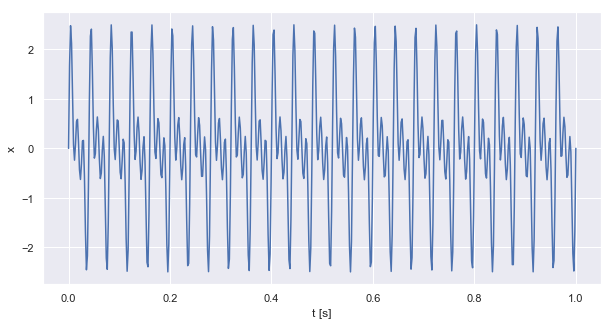

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(t, x)
plt.xlabel('t [s]')
plt.ylabel('x')
plt.show()

離散フーリエ変換して周波数領域の信号を作成します．

In [4]:
f = np.arange(-SAMPLING_RATE // 2, SAMPLING_RATE // 2)
X = fft(x, n=SAMPLING_RATE)

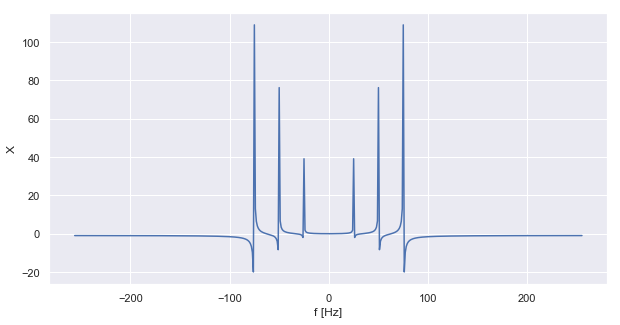

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(f, fftshift(X).real)
plt.xlabel('f [Hz]')
plt.ylabel('X')
plt.show()

ウェルチ法によって，信号のパワースペクトル密度を推定することができます．

In [6]:
P = welch(x, SAMPLING_RATE, nperseg=SAMPLING_RATE)

信号に含まれる周波数成分がそれぞれ$25 \rm{Hz}$，$50 \rm{Hz}$，$75 \rm{Hz}$であることが確認できます．

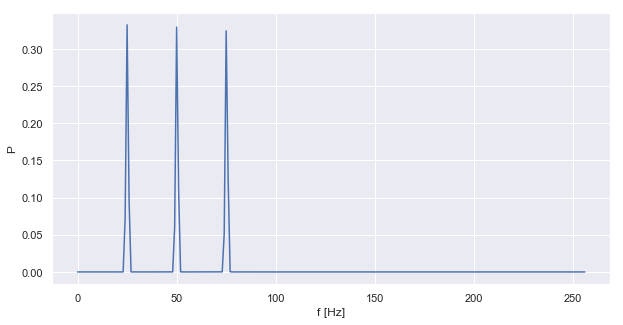

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(*P)
plt.xlabel('f [Hz]')
plt.ylabel('P')
plt.show()

含まれる主な周波数成分のうち，$25 \rm{Hz}$がもっとも低周波であることから，$25 \rm{Hz}$の正弦波を抽出するディジタルフィルタとしてローパスフィルタを考えます．

理想的なローパスフィルタは，入力された信号のうち，カットオフ周波数以下の周波数の信号をすべて出力し，カットオフ周波数を上回る周波数の信号をすべて遮断するので，インパルス応答は周波数領域では次のような矩形になります．

In [8]:
CUTOFF_FREQ = 25

ideal_H = np.abs(f) <= CUTOFF_FREQ

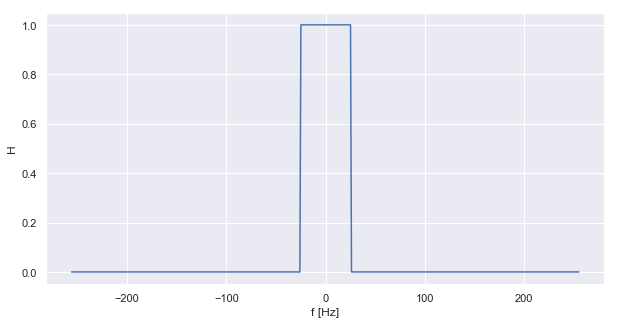

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(f, ideal_H)
plt.xlabel('f [Hz]')
plt.ylabel('H')
plt.show()

離散フーリエ逆変換してインパルス応答の時間領域での信号を作成します．

In [10]:
ideal_h = ifft(ifftshift(ideal_H))

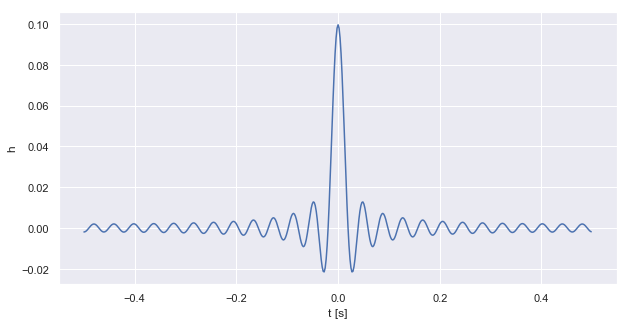

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(fftshift(fftfreq(SAMPLING_RATE)), fftshift(ideal_h).real)
plt.xlabel('t [s]')
plt.ylabel('h')
plt.show()

フィルタのインパルス応答は，以下のような単位インパルスを$0$秒に入力したときの出力です．

In [12]:
d = unit_impulse(SAMPLING_RATE, SAMPLING_RATE // 2)

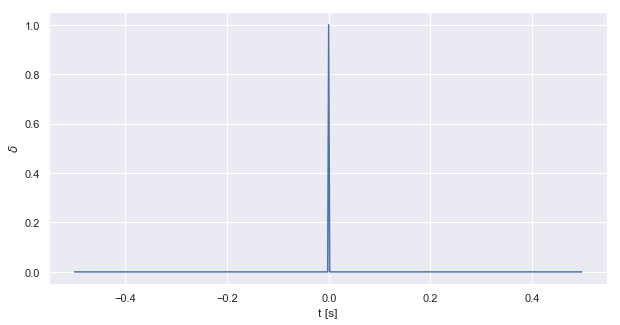

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(fftshift(fftfreq(SAMPLING_RATE)), d)
plt.xlabel('t [s]')
plt.ylabel(r'$\delta$')
plt.show()

$0$秒に単位インパルスを入力しているにもかかわらず，理想的なローパスフィルタのインパルス応答は$0$秒より以前に応答が存在しています．これは，**理想的なローパスフィルタが因果的でない**ことを示しています．つまり，**リアルタイム用途では理想的なローパスフィルタは実現不可能**であることがわかります．

そこで，因果性をみたすよう時間軸に沿ってインパルス応答波形を平行移動し，$0$秒以前の応答を無くします．さらに，インパルス応答を有限の時間に制限します．このように因果性を満たし，有限の時間に制限されるインパルス応答をもつディジタルフィルタをFIRフィルタといいます．

今回は応答を$41$，$51$，$61$点に制限したFIRフィルタを3つ作成し，比較しました．　

In [14]:
TAP = [41, 51, 61] 

causal_h = {}
for tap in TAP:
    shift = tap // 2
    h = fftshift(ideal_h) * (np.abs(f) <= shift)
    causal_h[tap] = np.pad(h, [shift, 0], mode='constant')[:-shift]

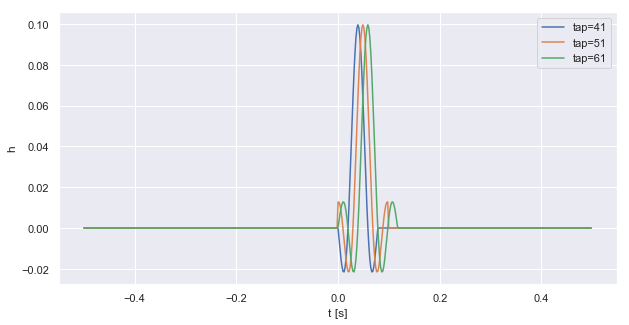

In [15]:
plt.figure(figsize=(10, 5))
for tap, h in causal_h.items():
    plt.plot(fftshift(fftfreq(SAMPLING_RATE)), h.real, label=f'tap={tap}')
plt.xlabel('t [s]')
plt.ylabel('h')
plt.legend()
plt.show()

結果，周波数領域でのインパルス応答の絶対値は以下のように，矩形にリップルが生じます．

In [16]:
causal_H = {}
for tap, h in causal_h.items():
    causal_H[tap] = fft(h)

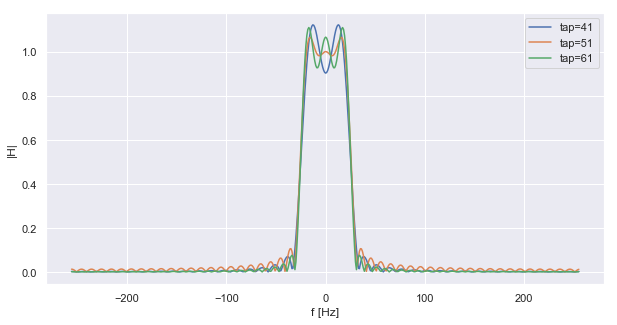

In [17]:
plt.figure(figsize=(10, 5))
for tap, H in causal_H.items():
    plt.plot(f, np.abs(fftshift(H)), label=f'tap={tap}')
plt.xlabel('f [Hz]')
plt.ylabel('|H|')
plt.legend()
plt.show()

信号をFIRフィルタに入力すると，$25 \rm{Hz}$の正弦波を抽出することができます．

In [18]:
y = {}
for tap, h in causal_h.items():
    y[tap] = convolve(x, h, mode='same')

tap=41


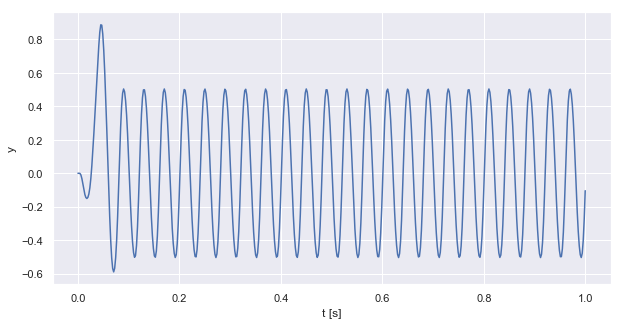

tap=51


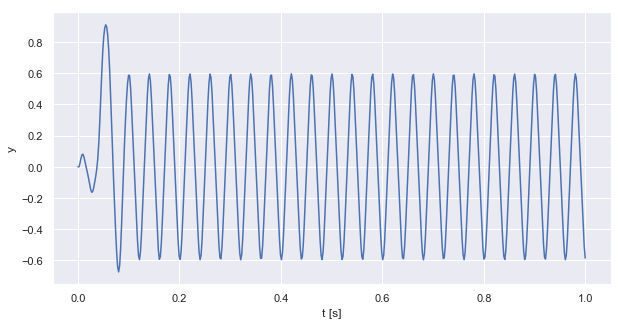

tap=61


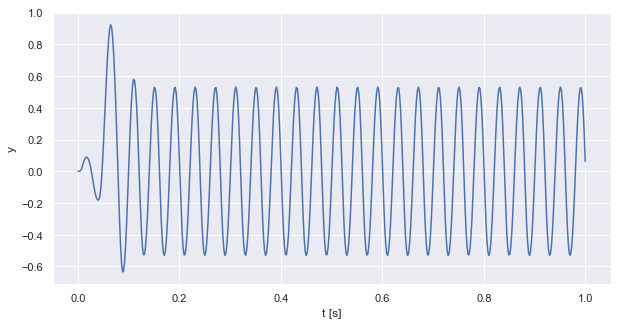

In [19]:
for tap, _y in y.items():
    print(f'tap={tap}')
    plt.figure(figsize=(10, 5))
    plt.plot(t, _y.real)
    plt.xlabel('t [s]')
    plt.ylabel('y')
    plt.show()

出力された信号の初期に注目すると，タップ数が大きいほど立ち上がりにかかる時間が長くなることがわかりました．

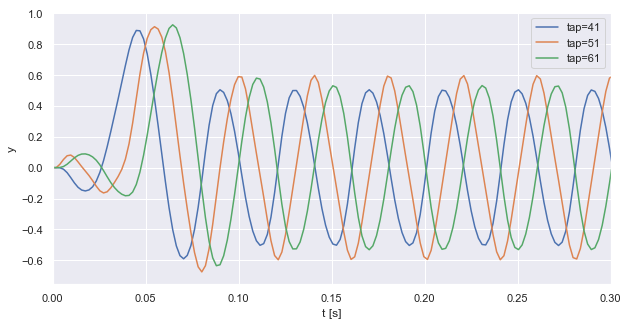

In [20]:
plt.figure(figsize=(10, 5))
for tap, _y in y.items():
    plt.plot(t, _y.real, label=f'tap={tap}')
plt.xlabel('t [s]')
plt.ylabel('y')
plt.xlim(0., 0.30)
plt.legend()
plt.show()

出力された信号の立ち上がり後に注目すると，タップ数が大きいほど入力信号に対する位相の遅れが大きくなるが，波形がより正弦波に近づくことがわかりました．

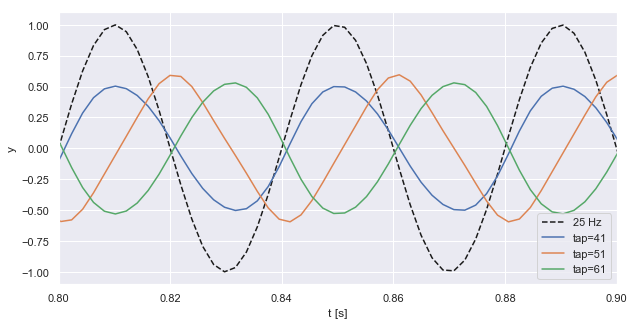

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(t, np.sin(2 * np.pi * 25 * t), label='25 Hz', color='k', linestyle="dashed")
for tap, _y in y.items():
    plt.plot(t, _y.real, label=f'tap={tap}')
plt.xlabel('t [s]')
plt.ylabel('y')
plt.xlim(0.80, 0.90)
plt.legend()
plt.show()